<h1 style="text-align:center;font-variant:small-caps;letter-spacing:2px;">Explorando um Método Espectral</h1>

### Motivação: soluções aproximadas de equações diferenciais
- Dado um espaço de funções escolhido a priori, qual função melhor aproxima a minha equação diferencial?


- Trabalharemos com o seguinte exemplo:

  Que polinômio de grau $\le 5$ melhor aproxima a solução de $u''(x) = x^2 - u(x)$, com condições de contorno $u(-1) = A, \; u'(1) = B$, sendo $A$ e $B$ fixos?

In [1]:
A = 2 ; B = 1/2 ; dim = basis_size = 6  # (grau máximo de cada polinômio = dim-1)

### Solução numérica: aspectos computacionais

- Notação para a solução aproximada: $u = \sum_k c_k \phi_k \equiv \langle \mathbf{\Phi}, \mathbf{c} \rangle$, sendo $\{\phi_0, \ldots, \phi_n\}$ nossa base de funções.


- Escolha de base: polinômios de Chebyshev, $\phi_n(x) = \cos (n \cdot \arccos(x)), \; x \in [-1,\ 1]$.
  - Várias [propriedades](https://en.wikipedia.org/wiki/Chebyshev_polynomials#Products_of_Chebyshev_polynomials) interessantes, como por exemplo satisfazerem à recorrência $\displaystyle \begin{cases} \phi_0(x) = 1; \\ \phi_1(x) = x; \\ \phi_{n+1}(x) = 2 x \, \phi_n(x) - \phi_{n-1}(x). \end{cases}$

  - Trata-se de uma sequência de funções ortogonais com relação à função peso $\omega(x) := 1 / \sqrt{1-x^2}$.
    - Wikipedia sobre polinômios [ortogonais](https://en.wikipedia.org/wiki/Orthogonal_polynomials#Absolutely_continuous_case)

    - Ou seja, para cada par $\phi_m, \phi_n$ de funções distintas da base, o produto interno $\langle \phi_m, \phi_n \rangle_\omega$ se anula:

  $$\langle \phi_m, \phi_n \rangle_\omega = \int_{-1}^1 \phi_m(x) \ \phi_n(x) \dfrac{dx}{\sqrt{1 - x^2}} = \begin{cases} 0, \; m \ne n; \\ \pi, \; m = n = 0; \\ \pi / 2, \; m = n \ne 0. \end{cases}$$

- Derivação / Integração
  - Cada problema envolve derivação, integração e outras operações elementares entre funções da base;

  - Tudo fica mais fácil se resolvermos cada uma dessas operações de maneira rápida e automática.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cvx
P = np.polynomial

def completar(a, size=dim, k=0):
    """Aumenta o tamanho de vetores para completar `size` entradas."""
    return np.lib.pad(a, (0, size-len(a)), 'constant', constant_values=(k,))

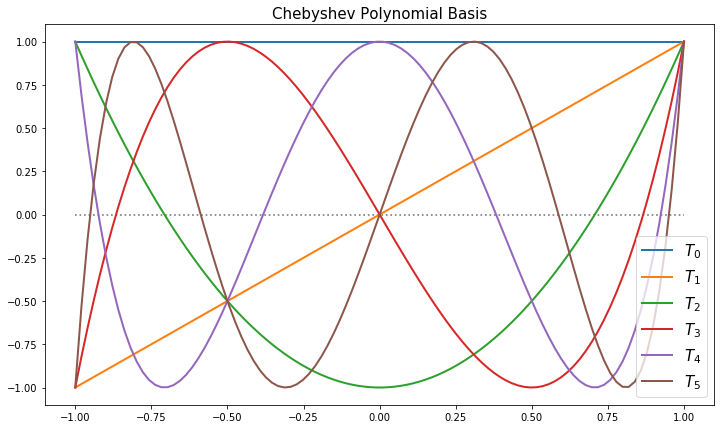

In [3]:
phi = [P.Chebyshev.basis(k) for k in range(basis_size)]  # polynomial basis

# Polinômio que representa f(x) = x**2, na base de Chebyshev:
x2_pol = P.Polynomial([0, 0, 1.]).convert(kind=P.Chebyshev)
x2_array = completar(x2_pol.coef)  # x4_coef = completar((x2_pol**2).coef)

fig, ax = plt.subplots(figsize=(12,7))
ax.set_title("Chebyshev Polynomial Basis", fontsize=15)
ax.plot([-1, 1], [0, 0], ':', color=(0,0,0,.5), lw=1.7)
for k,p in enumerate(phi):
    ax.plot(*p.linspace(100), lw=2, label="$T_{:d}$".format(k))
ax.legend(loc="lower right", framealpha=.75, fontsize=15) ; plt.show()

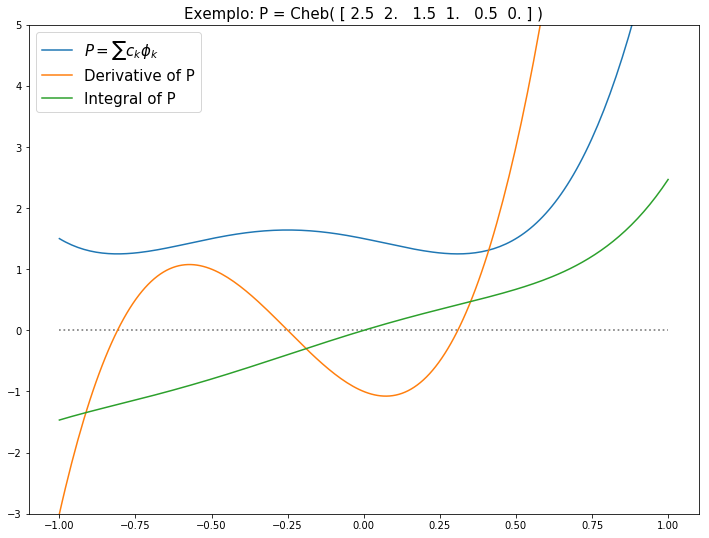

In [4]:
coefs = np.arange(0, .5 * basis_size, .5)[::-1]
lin_comb_pol = np.dot(coefs, phi)

fig, ax = plt.subplots(figsize=(12,9))
ax.set_title("Exemplo: P = Cheb( {} )".format(coefs), fontsize=15)
ax.plot([-1, 1], [0, 0], ':', color=(0,0,0,.5), lw=1.7)
ax.plot(*lin_comb_pol.linspace(200), label="$P = \\sum c_k \\phi_k$")
ax.plot(*lin_comb_pol.deriv().linspace(200), label="Derivative of P")
ax.plot(*lin_comb_pol.integ(k=0).linspace(200), label="Integral of P")
ax.legend(loc="upper left", fontsize=15)
ax.set_ylim((-3, 5)) ; plt.show()

### Voltando ao problema-exemplo:
$$\begin{cases} u''(x) = x^2 - u(x); \\ u(-1) = A, \; u'(1) = B \end{cases}$$
- Dada uma função candidata $\psi$, como saber se ela é uma boa solução para o problema?

### Escolha de uma *"função de custo"*
- Como queríamos que $u''(x)$ se igualasse a $x^2 - u(x)$, podemos penalizar, por exemplo, alguma função que cresça com essa diferença:
$$Q_0(\psi, x) = [\ \ddot\psi(x) - (x^2 - \psi(x)) \ ]^2.$$

  Mas para quais valores de $x$, exatamente?

  Uma resposta possível é "todos", simplesmente integrando $Q_0$ em $x \in [0,1]$:
$$Q_1(\psi) = \int_{-1}^1 [\ \ddot\psi(x) - (x^2 - \psi(x)) \ ]^2 \ dx.$$

  Com um pouco de fé, porém, podemos aproveitar a ortogonalidade de $\mathbf \Phi$ tomando a medida $d\omega(x) = \dfrac{dx}{\sqrt{1-x^2}}$:

$$Q(\psi) = \int_{-1}^1 [\ \ddot\psi(x) - (x^2 - \psi(x)) \ ]^2 \ \dfrac{dx}{\sqrt{1-x^2}}.$$

Observe que, se $u_\star$ é solução do problema, então $Q(u_\star) = 0$, mas que de um modo geral não é necessário que $u_\star \in \text{span} \{\phi_k, \, k \le n \}$.

### Representação:
- O mapa $x \mapsto x^2$ é identificado, por exemplo, com o vetor $\left[ \frac{1}{2}, 0, \frac{1}{2}, 0, 0, 0, \ldots, 0 \right]$, uma vez que $x^2 = \frac{1}{2}\phi_0(x) + \frac{1}{2}\phi_2(x)$.

- Precisamos das derivadas segundas das funções da base, visto que $\psi = \sum c_k \phi_k \, \text{ e } \, \ddot\psi = \sum c_k \phi_k'' = D^2 \psi$.

- É interessante investigarmos um pouco mais o produto interno $\langle \cdot, \, \cdot \rangle_\omega$, visto que a função de custo é quadrática.

In [5]:
# psi, identificada como operador sobre os coeficientes, corresponde à matriz identidade:
phi_matrix = np.eye(dim)

# Aproveitamos a implementação da biblioteca numpy para o cálculo de derivadas de polinômios:
d_phi  = [pol.deriv(m=1) for pol in phi]
d2_phi = [pol.deriv(m=2) for pol in phi]

# Pensando a diferenciação como operador, sua matriz tem como colunas as derivadas da base:
d2_phi_matrix = np.zeros((dim, dim))
for k,pol in enumerate(d2_phi):
    d2_phi_matrix[::, k] = completar(pol.coef) # (completando com zeros)

### Análise da função de custo:

Vimos que
$$Q(\psi) = \int_{-1}^1 \left[\ \psi(x) + \ddot\psi(x) - x^2 \ \right]^2 \ \dfrac{dx}{\sqrt{1-x^2}}.$$
e nesse momento lembramos que, em $d\omega(x) = w(x) \ dx$, cada produto de funções é simplificado:
$$\left( \sum_{i=0}^n c_i \phi_i \right)^2 = \left( \sum_{i=0}^n c_i \phi_i \right) \left( \sum_{j=0}^n c_j \phi_j \right) = \sum_i \sum_j c_i c_j \phi_i \phi_j,$$
logo
$$\langle \Phi \mathbf c, \Phi \mathbf c \rangle_\omega = \sum_i \sum_{j=i}^i c_i c_j \int_{-1}^1 \phi_i(x) \phi_j(x) \cdot \left[i=j\right] d\omega(x) = \sum_i c_i^2 \langle \phi_i, \, \phi_i \rangle_\omega.$$

Lembrando os valores de $\langle \phi_i, \, \phi_j \rangle_\omega$ e escrevendo $\mu \equiv \left[x \mapsto x^2\right]$, vemos que

$\displaystyle Q(\psi) = \left\langle [I + D^2] \mathbf{c} - \mu, [I + D^2] \mathbf{c} - \mu \right\rangle_\omega =$
$$= \left\langle [I + D^2] \mathbf{c} - \mu \;;\; \begin{bmatrix} \pi & 0 & 0 & \vdots \\ 0 & \pi/2 & 0 & \vdots \\ 0 & 0 & \pi/2 & \vdots \\ \ldots & \ldots & \ldots & \ddots \end{bmatrix} \;;\; [I + D^2] \mathbf{c} - \mu \right\rangle,$$
e desejamos minimizar essa tão bonita [forma quadrática](https://en.wikipedia.org/wiki/Quadratic_form#Real_quadratic_forms)... sob as restrições de contorno.

Vale observar que essa forma quadrática é [positiva definida](https://en.wikipedia.org/wiki/Positive-definite_matrix) e $[I+D^2] \mathbf{c} - \mu$ é uma função afim, donde $Q$ é [convexa](http://www.cvxpy.org/en/latest/tutorial/dcp/index.html#curvature-rules) e minimizá-la (sob restrições convexas) é uma tarefa relativamente fácil.

In [6]:
# Operador [identidade + segunda derivada] na base de Chebyshev:
id_plus_d2 = phi_matrix + d2_phi_matrix

# Forma Quadrática: M = diag(pi, pi/2, pi/2, ..., pi/2).
M = (np.pi/2) * np.ones(dim) ; M[0] = np.pi
M = cvx.diag(M)

### Condições de Contorno

Desejamos satisfazer às condições
$$\begin{cases} A = \psi(-1) = \sum_k c_k \ \phi_k(-1); \\ B = \dot\psi(+1) = \sum_k c_k \ \phi_k'(+1). \end{cases}$$

e o cálculo de $\phi_k(-1)$ e $\phi_k'(1)$ nos fornece duas restrições de igualdade lineares:

$$\begin{bmatrix} \phi_0(-1) & \ldots & \phi_n(-1) \\ \phi_0'(1) & \ldots & \phi_n'(1) \end{bmatrix} \begin{bmatrix} c_0 \\ \vdots \\ c_n \end{bmatrix} = \begin{bmatrix} A \\ B \end{bmatrix}$$

In [7]:
u = [p(-1) for p in phi]     # dot(u, c) = A
v = [dp(1) for dp in d_phi]  # dot(v, c) = B

In [8]:
c = cvx.Variable(dim, name="c")

cost = cvx.quad_form(id_plus_d2 * c - x2_array, M)
problem = cvx.Problem(cvx.Minimize(cost), constraints=[c.T @ u == A, c.T @ v == B])
problem.solve()

print("Problem value (optimal cost): {:.5e}".format(problem.value))
result_array = c.value.A.flatten()

Problem value (optimal cost): 3.30188e-05


In [9]:
print("http://web.stanford.edu/~boyd/papers/ecos.html")
problem.solver_stats.__dict__

http://web.stanford.edu/~boyd/papers/ecos.html


{'num_iters': 6,
 'setup_time': 4.5466e-05,
 'solve_time': 0.000115447,
 'solver_name': 'ECOS'}

Erros nas condições de contorno:
  |p(-1) - A| = 1.679e-13
  |p'(1) - B| = 2.836e-12


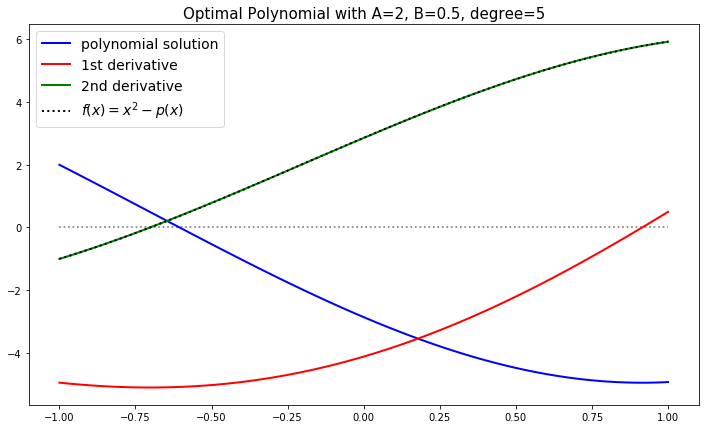

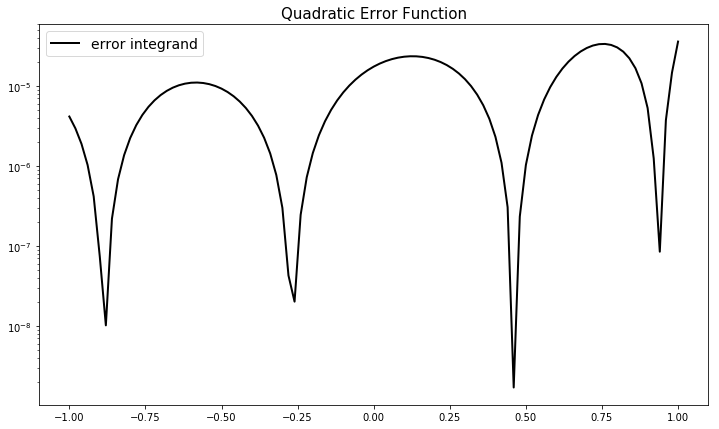

In [10]:
def plot_polynomials(list_of_plot_params, title, show_x_axis=True, semilogy=False):
    #print(result_pol.convert(kind="???"))
    fig, ax = plt.subplots(figsize=(12,7))
    ax.set_title(title, fontsize=15)

    if show_x_axis:
        ax.plot([-1, 1], [0, 0], ':', color=(0,0,0,.5), lw=1.7)

    for label,ss,pol in list_of_plot_params:
        ax.plot(*pol.linspace(101), ss, lw=2, label=label)

    ax.legend(loc=0, framealpha=.75, fontsize=14)
    if semilogy:
        ax.set_yscale("log")
    plt.show()

res = np.dot(result_array, phi)
d_res = res.deriv()
d2_res = res.deriv(m=2)

zz = [
  ("polynomial solution", 'b-', res),
  ("1st derivative",      'r-', d_res),
  ("2nd derivative",      'g-', d2_res),
  ("$f(x) = x^2 - p(x)$", 'k:', x2_pol - res),
]

print("Erros nas condições de contorno:")
print("  |p(-1) - A| = {:.3e}".format(abs(A - res(-1))))
print("  |p'(1) - B| = {:.3e}".format(abs(B - d_res(1))))

plot_polynomials(zz, "Optimal Polynomial with A={}, B={}, degree={}".format(A,B,dim-1))
plot_polynomials([("error integrand", 'k', (d2_res - (x2_pol - res))**2)], "Quadratic Error Function", False, True)

## Perguntas $\star%\heartsuit$

- Qual a solução analítica do problema proposto?


- Por que escolher o intervalo $[-1, 1]$, e como tratar casos mais gerais, $[a,b]$?


- Como fazer com que a forma quadrática fique com a matriz identidade, transformando-a no quadrado da norma de $[I + D^2] \mathbf{c} - \mu$? Imagina uma interpretação geométrica?


- O que acontece se tentarmos usar um outro produto interno, como o mais usual:
$$\langle f, g \rangle = \int_{-1}^1 f(x) \ g(x) \ dx\, ?$$


- Como generalizar a solução acima para modelos mais gerais? Daria pra fazer um método equivalente para dimensões maiores? E como você trataria um $\cos(x)$ no lugar de $x^2$?


- O que você achou mais interessante desse tipo de método? E mais complicado?